FIRST_NAME = "Mel"

LAST_NAME = "Gerst"

STUDENT_ID = "800995291"

Final Class Project - ITCS 5154

Dog Breed Classifier - Student Mel Gerst

Duplicating project originally by TechVidvan

In [1]:
# Dog Breed Classifier
# ITCS 5154 - Student Mel Gerst
# Duplicating project by TechVidvan
# Import necessary packages for dog breed classifier
import cv2
import numpy as np
import pandas as pd
import tensorflow
import pathlib
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2,preprocess_input

print("Imports Complete")
print(pathlib.Path().resolve())

from google.colab import drive
# drive._mount('/content/drive')
drive.mount('/content/drive/')
# My files are mounted in Google drive for access by Colab, stored in "My Drive/data.csv"
# file_path = '/content/drive/My Drive/data.csv'


Imports Complete
/content
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Initialize Variables
encoder = LabelEncoder()
image_size = 224
breed_count = 60
batch_size = 64


# Grab input files and data
df_labels = pd.read_csv("/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/labels.csv")
#store training and testing images folder location
training_data = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-data/train/'
testing_data =  '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-data/test/'

# Check and print the total number of unique breeds in original dataset
print("Total number of unique Dog Breeds in data:",len(df_labels.breed.unique()))
print(os.listdir(testing_data))

Total number of unique Dog Breeds in data: 120
['06b727fc8e24e46fd7ea78b08091cab5.jpg', 'b9394502a73a79ea161ff40332252eb4.jpg', '18cf06b0c6a59c6891bf6f5a42bcc73d.jpg', '23e9f1d6a1a0d5a7b495b3f4795187d8.jpg', '1439e842cb9f8b2c3fcc64806cf82728.jpg', 'ae2407346c1574ea24682aab76898d80.jpg', 'f7d9e21e792ce7d02af8faebffb715b4.jpg', 'ff66c9a0c51b47440e26b1b0ae2c047f.jpg', 'a8dba4a58717a26f645ba6099a897014.jpg', '35285831a42d652521a33132f01f6147.jpg', '41bb88e8da45c400490febc6d8d13689.jpg', 'c3853195a3d4c74b4fd3a9b841e4778b.jpg', '2ea4e19a736530e43cd659a54fdd5966.jpg', 'a781b14452fcb0716575e58d04c5d886.jpg', '7eb470b7b4efcbcdb88cd8a249fbafcf.jpg', '9e2301c48ea023a37d3b355f0e17b4f4.jpg', '44923308ee2ae1ed3c92ae941c6b1d4b.jpg', 'f41a03e617bde76fef19ec1cf1355d59.jpg', '240466d7cb9501fca06b5cc153f2ba88.jpg', 'ef154d61fb8fd0852877c86dbfc5afc6.jpg', '5b9ffbb373a5003493c9379e8e75b7fd.jpg', 'd2a440580e48f9004697bd6c13026a25.jpg', '3d0d318ff197407a09c0454a91c2ba8d.jpg', 'ca244b60ca88c2ea416f937f21a77e8

In [3]:
# Drop breeds considered to 60 breeds to speed up runtimes
breed_dict = list(df_labels['breed'].value_counts().keys())
new_list = sorted(breed_dict,reverse=True)[:breed_count*2:2]
# Limit dataset to have only those 60 unique breed records
df_labels = df_labels.query('breed in @new_list')
# Add new column which will contain image name with the image extension
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")
print("Total number of unique Dog Breeds used in model training:",len(df_labels.breed.unique()))
print("The breeds used for training and testing are:", sorted(df_labels.breed.unique()))

# Create a numpy array of the shape (number of dataset records, image size , image size, 3 for rgb channel layer)
# Input for model
train_x = np.zeros((len(df_labels), image_size, image_size, 3), dtype='float32')

Total number of unique Dog Breeds used in model training: 60
The breeds used for training and testing are: ['afghan_hound', 'airedale', 'appenzeller', 'basenji', 'beagle', 'bernese_mountain_dog', 'blenheim_spaniel', 'bluetick', 'border_terrier', 'boston_bull', 'boxer', 'briard', 'bull_mastiff', 'cardigan', 'chihuahua', 'clumber', 'collie', 'dandie_dinmont', 'dingo', 'english_foxhound', 'english_springer', 'eskimo_dog', 'french_bulldog', 'german_short-haired_pointer', 'golden_retriever', 'great_dane', 'greater_swiss_mountain_dog', 'ibizan_hound', 'irish_terrier', 'irish_wolfhound', 'japanese_spaniel', 'kelpie', 'komondor', 'labrador_retriever', 'leonberg', 'malamute', 'maltese_dog', 'miniature_pinscher', 'miniature_schnauzer', 'norfolk_terrier', 'norwich_terrier', 'otterhound', 'pekinese', 'pomeranian', 'redbone', 'rottweiler', 'saluki', 'schipperke', 'scottish_deerhound', 'shetland_sheepdog', 'siberian_husky', 'soft-coated_wheaten_terrier', 'standard_poodle', 'sussex_spaniel', 'tibetan

<ipython-input-3-e80864a923a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")


In [4]:
# #iterate over img_file column of our dataset
# for i, img_id in enumerate(df_labels['img_file']):
#   # Read the image file and convert into numeric format
#   # Resize all images to one dimension i.e. 224x224 set by image size
#   # We will get array with the shape of
#   # (224,224,3) where 3 is the RGB channels layers
#   img = cv2.resize(cv2.imread(training_data+img_id,cv2.IMREAD_COLOR),((image_size,image_size)))
#   # Scale array into the range of -1 to 1.
#   # Preprocess the array and expand its dimension on the axis 0
#   img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
#   # Update the train_x variable with new element
#   train_x[i] = img_array

In [5]:
# print(train_x.shape)
# np.save('/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-data/file1.npy', train_x)

In [6]:
train_x = np.load('/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-data/file1.npy')
print(train_x.shape)

(5175, 224, 224, 3)


In [7]:
# This will be target for model.
# Convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

# Split the dataset in the ratio of 80:20.
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [8]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Generate images for training sets
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=batch_size)

# Same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow(x_test,
                                     y_test,
                                     batch_size=batch_size)

In [9]:
# Model #1 - Build the model using ResNet50V2 with input shape of our image array
# Weights for our network will be from of imagenet dataset
# We will not include the first Dense layer
resnet = ResNet50V2(input_shape = [image_size,image_size,3], weights='imagenet', include_top=False)
# Freeze all trainable layers and train only top layers
for layer in resnet.layers:
    layer.trainable = False

# Add global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# Add fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

# Add output layer having the shape equal to number of breeds
predictions = Dense(breed_count, activation='softmax')(x)

# Create model class with inputs and outputs
model = Model(inputs=resnet.input, outputs=predictions)

In [10]:
# model.summary()

# Set the num_epochs for model training and learning rate for optimizer
num_epochs = 20
learning_rate = 1e-3

# Using RMSprop optimizer compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

# Fit the training generator data and train the model
model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= num_epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Resnet Test accuracy: {test_accuracy:.2f}')

# Save the model for prediction
model.save("model.keras")



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 69s 789ms/step - accuracy: 0.2997 - loss: 2.9479 - val_accuracy: 0.7412 - val_loss: 0.8319
Epoch 2/20
 1/64 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6719 - loss: 1.3859

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6719 - loss: 1.3859 - val_accuracy: 0.5455 - val_loss: 0.8800
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 583ms/step - accuracy: 0.6235 - loss: 1.2867 - val_accuracy: 0.7891 - val_loss: 0.6881
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.6562 - loss: 1.1582 - val_accuracy: 0.8182 - val_loss: 0.6260
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.6787 - loss: 1.0543 - val_accuracy: 0.7842 - val_loss: 0.6430
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5938 - loss: 1.3090 - val_accuracy: 0.8182 - val_loss: 0.6709
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 583ms/step - accuracy: 0.6980 - loss: 0.9979 - val_accuracy: 0.7939 - val_loss: 0.6584
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.6562 - loss: 1.2971 - val_accuracy: 1.0000 - val_loss: 0.1325
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 583ms/step - accuracy: 0.7119 - loss: 0.9489 - val_accuracy: 0.7988 - v

In [11]:
# Load the model
model = load_model("model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


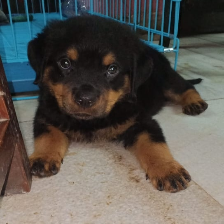

Predicted Breed for this Dog is : rottweiler
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


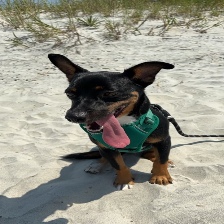

Predicted Breed for this Dog is : miniature_pinscher
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


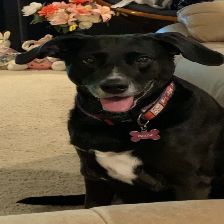

Predicted Breed for this Dog is : labrador_retriever
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


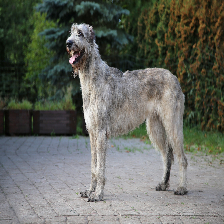

Predicted Breed for this Dog is : scottish_deerhound
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


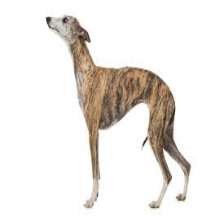

Predicted Breed for this Dog is : whippet
Check image size:  224


In [12]:
# Get the image of the dog #1 for prediction
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/rottweiler.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",predicted_breed)

# Get the image of the dog #2 for prediction
pred_img_path2 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/toby.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array2 = cv2.resize(cv2.imread(pred_img_path2,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array2 = preprocess_input(np.expand_dims(np.array(pred_img_array2[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val2 = model.predict(np.array(pred_img_array2,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path2,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed2 = sorted(new_list)[np.argmax(pred_val2)]
print("Predicted Breed for this Dog is :",predicted_breed2)

# Get the image of the dog #3 for prediction
pred_img_path3 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/bella.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array3 = cv2.resize(cv2.imread(pred_img_path3,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array3 = preprocess_input(np.expand_dims(np.array(pred_img_array3[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val3 = model.predict(np.array(pred_img_array3,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path3,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed3 = sorted(new_list)[np.argmax(pred_val3)]
print("Predicted Breed for this Dog is :",predicted_breed3)

# Get the image of the dog #4 for prediction
pred_img_path4 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/irishwolfhound.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array4 = cv2.resize(cv2.imread(pred_img_path4,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array4 = preprocess_input(np.expand_dims(np.array(pred_img_array4[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val4 = model.predict(np.array(pred_img_array4,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path4,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed4 = sorted(new_list)[np.argmax(pred_val4)]
print("Predicted Breed for this Dog is :",predicted_breed4)

# Get the image of the dog #5 for prediction
pred_img_path5 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/whippet.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array5 = cv2.resize(cv2.imread(pred_img_path5,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array5 = preprocess_input(np.expand_dims(np.array(pred_img_array5[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val5 = model.predict(np.array(pred_img_array5,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path5,cv2.IMREAD_COLOR),((image_size,image_size))))
#Display the predicted breed of dog
predicted_breed5 = sorted(new_list)[np.argmax(pred_val5)]
print("Predicted Breed for this Dog is :",predicted_breed5)
print("Check image size: ", image_size)

In [13]:
#VGG model
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# This will be target for model.
# Convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

# Assuming train_y is one-hot encoded, if not, you might need to do this
train_y = tf.keras.utils.to_categorical(train_y, num_classes=60)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)


def create_vgg_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model # Return both model and base_model

input_shape = (224, 224, 3)
num_classes = 60
model, base_model = create_vgg_model(input_shape, num_classes) # Get both returned values

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_test, y_test))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

base_model.trainable = True  # Now base_model is accessible here
for layer in base_model.layers[:-4]:  # Unfreeze the last few layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(x_train, y_train,
                              epochs=10,
                              batch_size=32,
                              validation_data=(x_test, y_test))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'VGG Test accuracy: {test_accuracy:.2f}')



Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.0210 - loss: 4.9276 - val_accuracy: 0.0647 - val_loss: 4.0010
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0375 - loss: 3.9490 - val_accuracy: 0.0763 - val_loss: 3.6539
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0616 - loss: 3.7077 - val_accuracy: 0.1343 - val_loss: 3.4547
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0874 - loss: 3.5136 - val_accuracy: 0.1546 - val_loss: 3.2972
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1173 - loss: 3.3143 - val_accuracy: 0.1981 - val_loss: 2.9391
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1388 - loss: 3.1435 - val_accuracy: 0.2213 - val_loss: 2.8961
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1688 - loss: 3.0214 - val_accuracy: 0.2338 - val_loss: 2.7337
Epoch 8/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1868 - loss: 2.8349 - val_acc

Check image size:  224
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


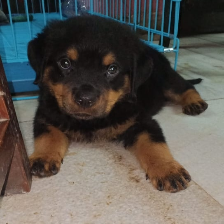

Predicted Breed for this Dog is : rottweiler
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


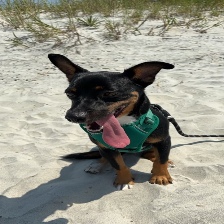

Predicted Breed for this Dog is : miniature_pinscher
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


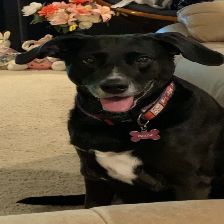

Predicted Breed for this Dog is : boxer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


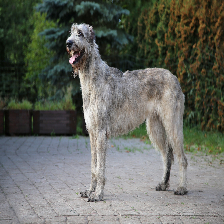

Predicted Breed for this Dog is : irish_wolfhound
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


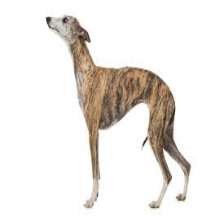

Predicted Breed for this Dog is : great_dane


In [14]:
# Second round of predictions with VGG model
print("Check image size: ", image_size)
# Get the image of the dog #1 for prediction
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/rottweiler.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",predicted_breed)

# Get the image of the dog #2 for prediction
pred_img_path2 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/toby.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array2 = cv2.resize(cv2.imread(pred_img_path2,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array2 = preprocess_input(np.expand_dims(np.array(pred_img_array2[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val2 = model.predict(np.array(pred_img_array2,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path2,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed2 = sorted(new_list)[np.argmax(pred_val2)]
print("Predicted Breed for this Dog is :",predicted_breed2)

# Get the image of the dog #3 for prediction
pred_img_path3 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/bella.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array3 = cv2.resize(cv2.imread(pred_img_path3,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array3 = preprocess_input(np.expand_dims(np.array(pred_img_array3[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val3 = model.predict(np.array(pred_img_array3,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path3,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed3 = sorted(new_list)[np.argmax(pred_val3)]
print("Predicted Breed for this Dog is :",predicted_breed3)

# Get the image of the dog #4 for prediction
pred_img_path4 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/irishwolfhound.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array4 = cv2.resize(cv2.imread(pred_img_path4,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array4 = preprocess_input(np.expand_dims(np.array(pred_img_array4[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val4 = model.predict(np.array(pred_img_array4,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path4,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed of dog
predicted_breed4 = sorted(new_list)[np.argmax(pred_val4)]
print("Predicted Breed for this Dog is :",predicted_breed4)

# Get the image of the dog #5 for prediction
pred_img_path5 = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/whippet.jpg'
# Read the image file and convert into numeric format
# Resize all images to one dimension i.e. 224x224
pred_img_array5 = cv2.resize(cv2.imread(pred_img_path5,cv2.IMREAD_COLOR),((image_size,image_size)))
# Scale array into the range of -1 to 1.
# Expand the dimesion on the axis 0 and normalize the array values
pred_img_array5 = preprocess_input(np.expand_dims(np.array(pred_img_array5[...,::-1].astype(np.float32)).copy(), axis=0))

# Feed the model with the image array for prediction
pred_val5 = model.predict(np.array(pred_img_array5,dtype="float32"))
# Display the image of dog
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path5,cv2.IMREAD_COLOR),((image_size,image_size))))
#Display the predicted breed of dog
predicted_breed5 = sorted(new_list)[np.argmax(pred_val5)]
print("Predicted Breed for this Dog is :",predicted_breed5)

In [15]:
print(len(np.unique(y_train)))

2


In [16]:
# new SimpleCNN model
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Assume train_x and train_y are defined
# train_x: numpy array of shape (5175, 224, 224, 3)
# train_y: numpy array of shape (5175,)

# Split the dataset
# x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Set batch size
# batch_size = 64

# Define data augmentation and normalization transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
y_train_indices = np.argmax(y_train, axis=1) # get the class indices from one-hot encoded y_train
y_test_indices = np.argmax(y_test, axis=1) # get the class indices from one-hot encoded y_test
train_dataset = CustomDataset(x_train, y_train_indices, transform=train_transforms) # use class indices for y_train
test_dataset = CustomDataset(x_test, y_test_indices, transform=test_transforms) # use class indices for y_test

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the SimpleCNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: 3 channels (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Calculate the input size for the first fully connected layer
        self.fc1_input_size = 128 * (224 // 8) * (224 // 8)  # After three pooling layers
        self.fc1 = nn.Linear(self.fc1_input_size, 256)
        self.fc2 = nn.Linear(256, 60)  # Output layer for 60 classes

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)  # Flatten the output
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
model.eval()  # Set model to evaluation mode
test_loss = 0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()  # Add to total loss
        pred = outputs.argmax(dim=1)  # Get the predicted class
        correct += (pred == labels).sum().item()  # Count correct predictions

test_accuracy = correct / len(test_dataset)
print(f'Test Loss: {test_loss/len(test_loader):.4f}, SimpleCNN Test Accuracy: {test_accuracy:.4f}')


Epoch [1/200], Loss: 4.0956
Epoch [2/200], Loss: 4.0909
Epoch [3/200], Loss: 4.1109
Epoch [4/200], Loss: 4.0628
Epoch [5/200], Loss: 4.0842
Epoch [6/200], Loss: 4.1168
Epoch [7/200], Loss: 4.0909
Epoch [8/200], Loss: 4.1123
Epoch [9/200], Loss: 4.0660
Epoch [10/200], Loss: 4.1158
Epoch [11/200], Loss: 4.0355
Epoch [12/200], Loss: 4.0377
Epoch [13/200], Loss: 4.0633
Epoch [14/200], Loss: 3.9654
Epoch [15/200], Loss: 3.9747
Epoch [16/200], Loss: 3.9040
Epoch [17/200], Loss: 4.0419
Epoch [18/200], Loss: 3.8912
Epoch [19/200], Loss: 3.9850
Epoch [20/200], Loss: 3.7673
Epoch [21/200], Loss: 3.9264
Epoch [22/200], Loss: 3.7417
Epoch [23/200], Loss: 3.8019
Epoch [24/200], Loss: 3.7246
Epoch [25/200], Loss: 3.7143
Epoch [26/200], Loss: 3.9530
Epoch [27/200], Loss: 3.6254
Epoch [28/200], Loss: 3.7152
Epoch [29/200], Loss: 3.7816
Epoch [30/200], Loss: 3.6019
Epoch [31/200], Loss: 3.5058
Epoch [32/200], Loss: 3.8346
Epoch [33/200], Loss: 3.7893
Epoch [34/200], Loss: 3.8105
Epoch [35/200], Loss: 3

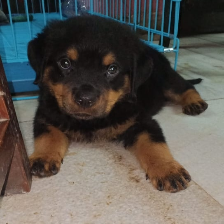

Predicted Breed for this Dog is: whippet


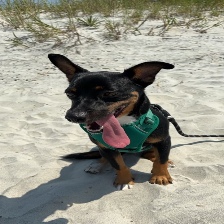

Predicted Breed for this Dog is: whippet


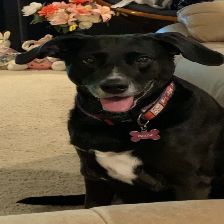

Predicted Breed for this Dog is: whippet


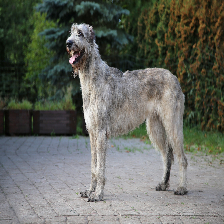

Predicted Breed for this Dog is: dingo


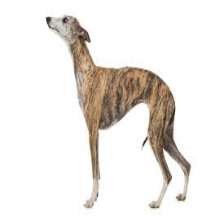

Predicted Breed for this Dog is: ibizan_hound


In [17]:
# Prediction 1
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/rottweiler.jpg'
# image_size = 224  # Resize to this if necessary

# Read and preprocess the image
pred_img_array = cv2.imread(pred_img_path)
pred_img_array = cv2.resize(pred_img_array, (image_size, image_size))
pred_img_tensor = transforms.ToTensor()(pred_img_array).unsqueeze(0).to(device)  # Add batch dimension

# Feed the model for prediction
with torch.no_grad():
    pred_val = model(pred_img_tensor)
    predicted_breed = sorted(new_list)[torch.argmax(pred_val).item()]

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed
print("Predicted Breed for this Dog is:", predicted_breed)

# Prediction 2
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/toby.jpg'
# image_size = 224  # Resize to this if necessary

# Read and preprocess the image
pred_img_array = cv2.imread(pred_img_path)
pred_img_array = cv2.resize(pred_img_array, (image_size, image_size))
pred_img_tensor = transforms.ToTensor()(pred_img_array).unsqueeze(0).to(device)  # Add batch dimension

# Feed the model for prediction
with torch.no_grad():
    pred_val = model(pred_img_tensor)
    predicted_breed = sorted(new_list)[torch.argmax(pred_val).item()]

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed
print("Predicted Breed for this Dog is:", predicted_breed)

# Prediction 3
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/bella.jpg'
# image_size = 224  # Resize to this if necessary

# Read and preprocess the image
pred_img_array = cv2.imread(pred_img_path)
pred_img_array = cv2.resize(pred_img_array, (image_size, image_size))
pred_img_tensor = transforms.ToTensor()(pred_img_array).unsqueeze(0).to(device)  # Add batch dimension

# Feed the model for prediction
with torch.no_grad():
    pred_val = model(pred_img_tensor)
    predicted_breed = sorted(new_list)[torch.argmax(pred_val).item()]

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed
print("Predicted Breed for this Dog is:", predicted_breed)

# Prediction 4
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/irishwolfhound.jpg'
# image_size = 224  # Resize to this if necessary

# Read and preprocess the image
pred_img_array = cv2.imread(pred_img_path)
pred_img_array = cv2.resize(pred_img_array, (image_size, image_size))
pred_img_tensor = transforms.ToTensor()(pred_img_array).unsqueeze(0).to(device)  # Add batch dimension

# Feed the model for prediction
with torch.no_grad():
    pred_val = model(pred_img_tensor)
    predicted_breed = sorted(new_list)[torch.argmax(pred_val).item()]

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed
print("Predicted Breed for this Dog is:", predicted_breed)

# Prediction 5
pred_img_path = '/content/drive/My Drive/ColabNotebooks/DogBreedClassifierProject/AI-model/whippet.jpg'
# image_size = 224  # Resize to this if necessary

# Read and preprocess the image
pred_img_array = cv2.imread(pred_img_path)
pred_img_array = cv2.resize(pred_img_array, (image_size, image_size))
pred_img_tensor = transforms.ToTensor()(pred_img_array).unsqueeze(0).to(device)  # Add batch dimension

# Feed the model for prediction
with torch.no_grad():
    pred_val = model(pred_img_tensor)
    predicted_breed = sorted(new_list)[torch.argmax(pred_val).item()]

from google.colab.patches import cv2_imshow
cv2_imshow(cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((image_size,image_size))))
# Display the predicted breed
print("Predicted Breed for this Dog is:", predicted_breed)